# Notebook to forecast quantiles for the DAX

# Imports

In [3]:
import pandas as pd
import numpy as np
import statsmodels as sm
import yfinance as yf
from datetime import datetime
import requests
import json
import sys
import math
import matplotlib.pyplot as plt
import scipy

from prophet import Prophet

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

import arch
from arch import arch_model

#from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
#from darts.utils.likelihood_models import GaussianLikelihood
#from darts.timeseries import TimeSeries

pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', sys.maxsize)

# Functions

In [4]:
def create_submission(daxmodel, energymodel):
    submission = create_submission_table()
    daxquantiles = daxmodel
    energyquantiles = energymodel
    for i in range(5):
        submission.loc[i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = daxquantiles[i]
    for i in range(6):
        submission.loc[5+i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = energyquantiles[i]
    return submission

def daxdataAtDate(daxdata, date):
    return daxdata.loc[daxdata.index <= date]

def energydataAtDate(energydata, date):
    return energydata.loc[energydata.index <= date + " 22:00:00"]

def quantile_loss(y_true, y_pred, quantile):
    
    if y_true > y_pred:
        loss = quantile * (y_true - y_pred)
    else:
        loss = (1 - quantile) * (y_pred - y_true)
    return loss

def energy_eval(energydata, p, q):
    energytraindata = energydata[:-168]
    energytestdata = energydata[-168:]

    enf12 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 12)]
    enf16 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 16)]
    enf20 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 20)]

    ens12 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 12)]
    ens16 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 16)]
    ens20 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 20)]

    energytestdata = pd.concat([enf12, enf16, enf20, ens12, ens16, ens20])

    energyforecast = energy_model(energytraindata, p, q)
    energyforecast = pd.DataFrame(energyforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

    energyevaldata = energytestdata.copy(deep=True)
    energyevaldata["q0.025"] = np.array(energyforecast["q0.025"])
    energyevaldata["q0.25"] = np.array(energyforecast["q0.25"])
    energyevaldata["q0.5"] = np.array(energyforecast["q0.5"])
    energyevaldata["q0.75"] = np.array(energyforecast["q0.75"])
    energyevaldata["q0.975"] = np.array(energyforecast["q0.975"])

    energyevaldata.data = energyevaldata.data / 1000

    energyevaldata.plot()

    totalloss = 0
    for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
        for i in range(len(energyevaldata)):
            totalloss += quantile_loss(energyevaldata["data"].iloc[i], energyevaldata[q].iloc[i], float(q[1:]))
    print("*********************************")
    print("Quantile Loss: " + str(totalloss))
    print("*********************************")

    return totalloss

def dax_eval(daxdata, p, q):
    daxtraindata = daxdata[:-5]
    daxtestdata = daxdata[-5:]

    daxforecast = dax_model(daxtraindata, p, q)
    daxforecast = pd.DataFrame(daxforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])
    daxevaldata = daxtestdata.copy(deep=True)

    daxevaldata["q0.025"] = np.array(daxforecast["q0.025"])
    daxevaldata["q0.25"] = np.array(daxforecast["q0.25"])
    daxevaldata["q0.5"] = np.array(daxforecast["q0.5"])
    daxevaldata["q0.75"] = np.array(daxforecast["q0.75"])
    daxevaldata["q0.975"] = np.array(daxforecast["q0.975"])
  
    daxevaldata.plot()

    totalloss = 0
    for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
        for i in range(len(daxevaldata)):
            totalloss += quantile_loss(daxevaldata["data"].iloc[i], daxevaldata[q].iloc[i], float(q[1:]))
    print("*********************************")
    print("Quantile Loss: " + str(totalloss))
    print("*********************************")

    return totalloss

def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

def create_submission_table():
    forecast_date = [str(datetime.now().date())] * 16
    target = ["DAX"] * 5 + ["energy"] * 6 + ["wind"] * 5
    horizon = ['1 day', '2 day', '5 day', '6 day', '7 day', '36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour', '36 hour', '48 hour', '60 hour', '72 hour', '84 hour']
    
    return pd.DataFrame({"forecast_date": forecast_date, "target": target, "horizon": horizon, "q0.025": [np.nan]*16, "q0.25": [np.nan]*16, "q0.5": [np.nan]*16, "q0.75": [np.nan]*16, "q0.975": [np.nan]*16})

def get_dax_data():
    msft = yf.Ticker("^GDAXI")
    hist = msft.history(period="max")
    data = hist[["Close"]]
    data = data.reset_index().rename(columns={"Date": "date_time"})
    data.set_index("date_time", inplace = True)
    data["data"] = compute_return(data.Close.values)
    data = data.dropna()
    data = data.drop(columns = "Close")
    #data = data.data.values
    
    return data

def get_energy_data(): 
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    timestamps = list(response.json()["timestamps"])

    energydata = pd.DataFrame(columns=["date_time", "data"])
    for stamp in timestamps[157:]:
        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]
        for i in range(len(rawdata)):
            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")
        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=["date_time", "data"])])
    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    energydata.set_index("date_time", inplace=True)
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

def create_submission_file(submission):
    submission.to_csv(datetime.now().strftime("%Y%m%d") + "_GreyWorm.csv", index = False)
    print("Submission file created")

# Current Models

In [5]:
def dax_model(daxdata, p, q):
    yhat = []
    for j in range(1,6):
        d = []
        step = j
        for i in range(len(daxdata)-1, 5, -1):
            d.append(daxdata["data"][i: i-step: -1].sum())
        d = d[::-1]
        df = daxdata.copy()
        df = df[6:]
        df["data"] = d

        model = arch_model(df, mean='Zero', vol='GARCH', p=8, q=0)
        model_fit = model.fit()
        yhat.append(model_fit.forecast(horizon=5))

    h1sample = np.random.normal(loc=0, scale=math.sqrt(yhat[0].variance["h.1"].iloc[-1]), size=1000)
    h2sample = np.random.normal(loc=0, scale=math.sqrt(yhat[1].variance["h.2"].iloc[-1]), size=1000)
    h3sample = np.random.normal(loc=0, scale=math.sqrt(yhat[2].variance["h.3"].iloc[-1]), size=1000)
    h4sample = np.random.normal(loc=0, scale=math.sqrt(yhat[3].variance["h.4"].iloc[-1]), size=1000)
    h5sample = np.random.normal(loc=0, scale=math.sqrt(yhat[4].variance["h.5"].iloc[-1]), size=1000)

    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

    h1quantiles = np.quantile(h1sample, quantiles)
    h2quantiles = np.quantile(h2sample, quantiles)
    h3quantiles = np.quantile(h3sample, quantiles)
    h4quantiles = np.quantile(h4sample, quantiles)
    h5quantiles = np.quantile(h5sample, quantiles)
    daxquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles]

    return daxquantiles

In [6]:
def energy_model(energydata, p, q):
    energydata = energydata.loc[energydata.data != 0]
    
    enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
    enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
    enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

    ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
    ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
    ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

    dfs = [enf12, enf16, enf20, ens12, ens16, ens20]
    params = pd.DataFrame(columns = ["h1", "h2", "h3", "h4", "h5", "h6"])
    for i, df in enumerate(dfs):
        model = ARIMA(df.data, order=(p,1,q))
        model_fit = model.fit()
        fc = float(model_fit.forecast(1))
        params[params.columns[i]] = [fc, float(df[-8:].describe().loc["std"])]

    h1sample = np.random.normal(loc=float(params.iloc[0].h1), scale=float(params.iloc[1].h1), size=1000)
    h2sample = np.random.normal(loc=float(params.iloc[0].h2), scale=float(params.iloc[1].h2), size=1000)
    h3sample = np.random.normal(loc=float(params.iloc[0].h3), scale=float(params.iloc[1].h3), size=1000)
    h4sample = np.random.normal(loc=float(params.iloc[0].h4), scale=float(params.iloc[1].h4), size=1000)
    h5sample = np.random.normal(loc=float(params.iloc[0].h5), scale=float(params.iloc[1].h5), size=1000)
    h6sample = np.random.normal(loc=float(params.iloc[0].h6), scale=float(params.iloc[1].h6), size=1000)

    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

    h1quantiles = np.quantile(h1sample, quantiles)
    h2quantiles = np.quantile(h2sample, quantiles)
    h3quantiles = np.quantile(h3sample, quantiles)
    h4quantiles = np.quantile(h4sample, quantiles)
    h5quantiles = np.quantile(h5sample, quantiles)
    h6quantiles = np.quantile(h6sample, quantiles)

    energyquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles, h6quantiles]
    energyquantiles = [q/1000 for q in energyquantiles]

    return energyquantiles

In [131]:
def dax_prophet_model(daxdata):
    pdax = daxdata.reset_index().rename(columns={"date_time": "ds", "data": "y"})
    pdax.loc[:, "ds"] = pdax['ds'].dt.tz_localize(None) 
    daxfuts = [mdax.make_future_dataframe(periods=1), mdax.make_future_dataframe(periods=2), mdax.make_future_dataframe(periods=5), mdax.make_future_dataframe(periods=6), mdax.make_future_dataframe(periods=7)]
    daxquantiles = []
    step = 1 
    for daxfut in daxfuts:
        d = []
        for i in range(len(pdax)-1, 5, -1):
            d.append(pdax["y"][i: i-step: -1].sum())
        d = d[::-1]
        df = pdax.copy()
        df = df[6:]
        df["y"] = d
        print(df.head(10))

        daxforc95 = Prophet(interval_width=0.95).fit(df).predict(daxfut)
        daxforc50 = Prophet(interval_width=0.50).fit(df).predict(daxfut)
        daxquantiles.append([daxforc95.iloc[-1].yhat_lower, daxforc50.iloc[-1].yhat_lower, daxforc50.iloc[-1].yhat, daxforc50.iloc[-1].yhat_upper, daxforc95.iloc[-1].yhat_upper])
        
        step += 1

    return daxquantiles

In [152]:
def energy_prophet_model(energydata):
    penergy = energydata.reset_index().rename(columns={"date_time": "ds", "data": "y"})
    menergy95 = Prophet(interval_width=0.95).fit(penergy)
    menergy50 = Prophet(interval_width=0.50).fit(penergy)
    energyfuts = [menergy95.make_future_dataframe(periods=38, freq="H"), menergy95.make_future_dataframe(periods=42, freq="H"), menergy95.make_future_dataframe(periods=46, freq="H"), menergy95.make_future_dataframe(periods=62, freq="H"), menergy95.make_future_dataframe(periods=66, freq="H"), menergy95.make_future_dataframe(periods=70, freq="H")]
    energyquantiles = []
    for energyfut in energyfuts:
        energyforc95 = menergy95.predict(energyfut)
        energyforc50 = menergy50.predict(energyfut)
        energyquantiles.append([energyforc95.iloc[-1].yhat_lower/1000, energyforc50.iloc[-1].yhat_lower/1000, energyforc50.iloc[-1].yhat/1000, energyforc50.iloc[-1].yhat_upper/1000, energyforc95.iloc[-1].yhat_upper/1000])
    return energyquantiles

# Development

In [35]:
create_submission(daxdataAtDate(daxdata, "2022-12-21"), energydataAtDate(energydata, "2022-12-21"))

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22021.61241652663
Iteration:      2,   Func. Count:     25,   Neg. LLF: 286486.98997125635
Iteration:      3,   Func. Count:     36,   Neg. LLF: 242422.30504102792
Iteration:      4,   Func. Count:     47,   Neg. LLF: 976627.309944535
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1381485.4843418046
Iteration:      6,   Func. Count:     69,   Neg. LLF: 2958188.2571356944
Iteration:      7,   Func. Count:     80,   Neg. LLF: 7495521.491374659
Iteration:      8,   Func. Count:     91,   Neg. LLF: 147265.7093252616
Iteration:      9,   Func. Count:    102,   Neg. LLF: 118821.37127683482
Iteration:     10,   Func. Count:    114,   Neg. LLF: 30435.24193702721
Iteration:     11,   Func. Count:    125,   Neg. LLF: 18273.684222031927
Iteration:     12,   Func. Count:    138,   Neg. LLF: 17399.921567204277
Iteration:     13,   Func. Count:    149,   Neg. LLF: 14946.82382613267
Iteration:     14,   Func. Count:    160,   Neg. LLF: 1445

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/t

forecast_date  target  horizon     q0.025      q0.25       q0.5      q0.75  \
0     2023-01-10     DAX    1 day  -2.546601  -0.974699  -0.057160   0.806885   
1     2023-01-10     DAX    2 day  -2.667867  -0.983246  -0.047993   0.948731   
2     2023-01-10     DAX    5 day  -2.734652  -0.918970  -0.011575   0.945153   
3     2023-01-10     DAX    6 day  -3.185961  -1.071660   0.028967   1.115240   
4     2023-01-10     DAX    7 day  -2.520502  -0.869056  -0.014317   0.839564   
5     2023-01-10  energy  36 hour  63.564874  65.411392  66.479714  67.500293   
6     2023-01-10  energy  40 hour  59.619154  63.437805  65.305036  67.376445   
7     2023-01-10  energy  44 hour  56.185542  59.433649  61.024033  62.791512   
8     2023-01-10  energy  60 hour  54.853287  58.028138  59.717057  61.332728   
9     2023-01-10  energy  64 hour  52.309904  57.727430  60.663162  63.226543   
10    2023-01-10  energy  68 hour  52.030866  55.997594  57.906874  59.968413   
11    2023-01-10    wind  36 hour        NaN        NaN        NaN        NaN   
12    2023-01-10    wind  48 hour        NaN        NaN        NaN        NaN   
13    2023-01-10    wind  60 hour        NaN        NaN        NaN        NaN   
14    2023-01-10    wind  72 hour        NaN        NaN        NaN        NaN   
15    2023-01-10    wind  84 hour        NaN        NaN        NaN        NaN   

       q0.975  
0    2.477481  
1    2.943678  
2    2.931334  
3    3.031010  
4    2.376785  
5   69.387863  
6   70.954609  
7   66.479754  
8   64.457113  
9   68.152873  
10  63.867030  
11        NaN  
12        NaN  
13        NaN  
14        NaN  
15        NaN

# Modeling

## DAX

### GARCH

In [ ]:
daxdata = get_dax_data()

In [46]:
model = arch_model(daxtraindata, mean='Zero', vol='GARCH', p=8, q=0)

In [47]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     11,   Neg. LLF: 21987.052345579705
Iteration:      2,   Func. Count:     25,   Neg. LLF: 938241.0751811876
Iteration:      3,   Func. Count:     36,   Neg. LLF: 212869.26953076536
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3103041.7307996266
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1135931.3395410213
Iteration:      6,   Func. Count:     69,   Neg. LLF: 2352846.1306259623
Iteration:      7,   Func. Count:     80,   Neg. LLF: 5439360.131719231
Iteration:      8,   Func. Count:     91,   Neg. LLF: 151381.36406252274
Iteration:      9,   Func. Count:    102,   Neg. LLF: 118675.54059931201
Iteration:     10,   Func. Count:    114,   Neg. LLF: 32093.021593741127
Iteration:     11,   Func. Count:    125,   Neg. LLF: 18297.262599226837
Iteration:     12,   Func. Count:    138,   Neg. LLF: 17301.787239976205
Iteration:     13,   Func. Count:    149,   Neg. LLF: 14929.26711275553
Iteration:     14,   Func. Count:    160,   Neg. LLF: 

In [ ]:
ret2 = daxdata.data**2

In [ ]:
ret2.plot()

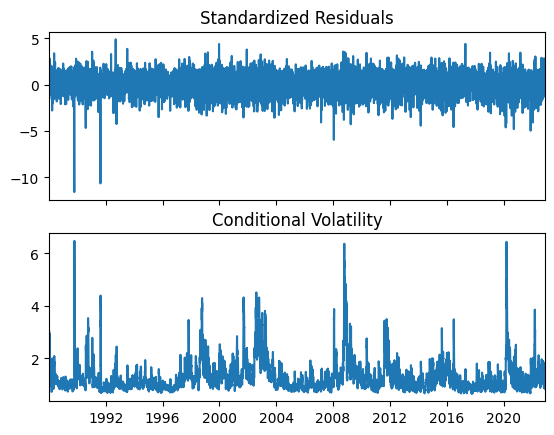

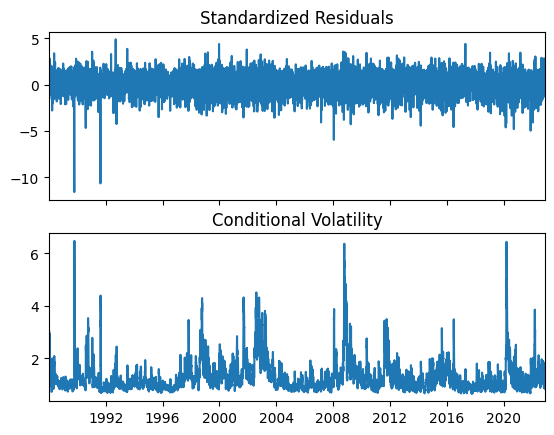

In [48]:
model_fit.plot()

In [49]:
yhat = model_fit.forecast(horizon=5)
yhat.variance.tail()

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


h.1       h.2       h.3       h.4       h.5
date_time                                                                  
2022-11-24 00:00:00+01:00       NaN       NaN       NaN       NaN       NaN
2022-11-25 00:00:00+01:00       NaN       NaN       NaN       NaN       NaN
2022-11-28 00:00:00+01:00       NaN       NaN       NaN       NaN       NaN
2022-11-29 00:00:00+01:00       NaN       NaN       NaN       NaN       NaN
2022-11-30 00:00:00+01:00  0.729746  0.687142  0.710302  0.850355  0.855785

In [50]:
h1sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.1"].iloc[-1]), size=1000)
h2sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.2"].iloc[-1]), size=1000)
h3sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.3"].iloc[-1]), size=1000)
h4sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.4"].iloc[-1]), size=1000)
h5sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.5"].iloc[-1]), size=1000)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

h1quantiles = np.quantile(h1sample, quantiles)
h2quantiles = np.quantile(h2sample, quantiles)
h3quantiles = np.quantile(h3sample, quantiles)
h4quantiles = np.quantile(h4sample, quantiles)
h5quantiles = np.quantile(h5sample, quantiles)
daxquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles]

### Prophet

In [100]:
pdax = daxdata.reset_index().rename(columns={"date_time": "ds", "data": "y"})
pdax.loc[:, "ds"] = pdax['ds'].dt.tz_localize(None)

In [77]:
mdax = Prophet().fit(pdax)
daxfuts = [mdax.make_future_dataframe(periods=1), mdax.make_future_dataframe(periods=2), mdax.make_future_dataframe(periods=5), mdax.make_future_dataframe(periods=6), mdax.make_future_dataframe(periods=7)]

In [105]:
d= []
for i in range(len(pdax)-1, 5, -1):
    d.append(pdax["y"][i: i-2: -1].sum())
d = d[::-1]
df = pdax.copy()
df = df[6:]
df["y"] = d
print(df.head(10))

           ds         y
6  1988-01-12 -3.953666
7  1988-01-13 -2.227104
8  1988-01-14 -1.267511
9  1988-01-15 -1.387760
10 1988-01-18  2.899690
11 1988-01-19  2.868809
12 1988-01-20 -4.348888
13 1988-01-21 -3.207457
14 1988-01-22  0.626907
15 1988-01-25  1.400747


In [110]:
daxquantiles = []
step = 1 
for daxfut in daxfuts:
    d = []
    for i in range(len(pdax)-1, 5, -1):
        d.append(pdax["y"][i: i-step: -1].sum())
    d = d[::-1]
    df = pdax.copy()
    df = df[6:]
    df["y"] = d
    print(df.head(10))

    daxforc95 = Prophet(interval_width=0.95).fit(df).predict(daxfut)
    daxforc50 = Prophet(interval_width=0.50).fit(df).predict(daxfut)
    daxquantiles.append([daxforc95.iloc[-1].yhat_lower, daxforc50.iloc[-1].yhat_lower, daxforc50.iloc[-1].yhat, daxforc50.iloc[-1].yhat_upper, daxforc95.iloc[-1].yhat_upper])
    
    step += 1


## Energy

### ARMA 

In [ ]:
energydata = get_energy_data()

In [ ]:
energydata = energydata.loc[energydata.data != 0]

In [ ]:
energydata.plot()

In [ ]:
enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

In [ ]:
ts12 = ens12.copy()
ts12.data = compute_return(ens12.data.values)
ts12 = t12.dropna()
ts12.plot()
plot_pacf(ts12.data, lags=104)


In [ ]:
model = ARIMA(ens12.data, order=(3,1,2))
model_fit = model.fit()
print(model_fit.summary())


In [ ]:
list(model_fit.params)[1:-1]

In [ ]:
arcoefs = [1] + list(model_fit.params)[1:-1][0:3] #0:p
macoefs = [1] + list(model_fit.params)[1:-1][3:3+2] #p:p+q
armadata = ArmaProcess(arcoefs, macoefs).generate_sample(nsample=1000)
pd.DataFrame(armadata).plot()

In [ ]:
pred = model_fit.get_prediction().summary_frame()

In [ ]:
#plot_predict(model_fit)
plt.plot(ens12.index, ens12.data)
plt.plot(pred.iloc[1:].index, pred.iloc[1:]['mean'])
plt.plot(pd.DataFrame(fc).index, pd.DataFrame(fc).predicted_mean)
plt.show()

In [ ]:
fc = model_fit.forecast(1) 

In [ ]:
float(fc)

In [ ]:
float(ens12[-5:].describe().loc["std"])

In [ ]:
dfs = [enf12, enf16, enf20, ens12, ens16, ens20]
params = pd.DataFrame(columns = ["h1", "h2", "h3", "h4", "h5", "h6"])
for i, df in enumerate(dfs):
    model = ARIMA(df.data, order=(3,1,2))
    model_fit = model.fit()
    fc = float(model_fit.forecast(1))
    params[params.columns[i]] = [fc, float(df[-8:].describe().loc["std"])]

In [ ]:
params

In [ ]:
h1sample = np.random.normal(loc=float(params.iloc[0].h1), scale=float(params.iloc[1].h1), size=1000)
h2sample = np.random.normal(loc=float(params.iloc[0].h2), scale=float(params.iloc[1].h2), size=1000)
h3sample = np.random.normal(loc=float(params.iloc[0].h3), scale=float(params.iloc[1].h3), size=1000)
h4sample = np.random.normal(loc=float(params.iloc[0].h4), scale=float(params.iloc[1].h4), size=1000)
h5sample = np.random.normal(loc=float(params.iloc[0].h5), scale=float(params.iloc[1].h5), size=1000)
h6sample = np.random.normal(loc=float(params.iloc[0].h6), scale=float(params.iloc[1].h6), size=1000)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

h1quantiles = np.quantile(h1sample, quantiles)
h2quantiles = np.quantile(h2sample, quantiles)
h3quantiles = np.quantile(h3sample, quantiles)
h4quantiles = np.quantile(h4sample, quantiles)
h5quantiles = np.quantile(h5sample, quantiles)
h6quantiles = np.quantile(h6sample, quantiles)

energyquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles, h6quantiles]
energyquantiles = [q/1000 for q in energyquantiles]

### Prophet

In [111]:
penergy = energydata.reset_index().rename(columns={"date_time": "ds", "data": "y"})

In [126]:
penergy = penergy.iloc[:-10]

ds
45136 2023-02-24 16:00:00
45137 2023-02-24 17:00:00
45138 2023-02-24 18:00:00
45139 2023-02-24 19:00:00
45140 2023-02-24 20:00:00

In [127]:
menergy95 = Prophet(interval_width=0.95).fit(penergy)
menergy50 = Prophet(interval_width=0.50).fit(penergy)
energyfuts = [menergy95.make_future_dataframe(periods=38, freq="H"), menergy95.make_future_dataframe(periods=42, freq="H"), menergy95.make_future_dataframe(periods=46, freq="H"), menergy95.make_future_dataframe(periods=62, freq="H"), menergy95.make_future_dataframe(periods=66, freq="H"), menergy95.make_future_dataframe(periods=70, freq="H")]
energyquantiles = []
for energyfut in energyfuts:
    energyforc95 = menergy95.predict(energyfut)
    energyforc50 = menergy50.predict(energyfut)
    energyquantiles.append([energyforc95.iloc[-1].yhat_lower, energyforc50.iloc[-1].yhat_lower, energyforc50.iloc[-1].yhat, energyforc50.iloc[-1].yhat_upper, energyforc95.iloc[-1].yhat_upper])

16:36:37 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:14 - cmdstanpy - INFO - Chain [1] start processing
16:37:47 - cmdstanpy - INFO - Chain [1] done processing


In [130]:
energyforc95.tail()

ds         trend    yhat_lower    yhat_upper  \
45160 2023-02-25 16:00:00  51698.310579  46868.514968  60930.004280   
45161 2023-02-25 17:00:00  51697.701084  47621.054916  61158.456646   
45162 2023-02-25 18:00:00  51697.091588  47161.621434  61003.111989   
45163 2023-02-25 19:00:00  51696.482093  47457.796801  61005.630794   
45164 2023-02-25 20:00:00  51695.872597  44709.780877  58357.853908   

        trend_lower   trend_upper  additive_terms  additive_terms_lower  \
45160  51698.310579  51699.295298     2435.130482           2435.130482   
45161  51697.701084  51698.773537     2671.361923           2671.361923   
45162  51697.091588  51698.250724     2864.096620           2864.096620   
45163  51696.482093  51697.727911     2063.962285           2063.962285   
45164  51695.872597  51697.203296     -148.552492           -148.552492   

       additive_terms_upper        daily  daily_lower  daily_upper  \
45160           2435.130482  4235.089272  4235.089272  4235.089272   
45161           2671.361923  4845.259727  4845.259727  4845.259727   
45162           2864.096620  5392.228621  5392.228621  5392.228621   
45163           2063.962285  4924.101277  4924.101277  4924.101277   
45164           -148.552492  3018.946192  3018.946192  3018.946192   

            weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
45160 -7242.449953  -7242.449953  -7242.449953  5442.491163   5442.491163   
45161 -7614.767759  -7614.767759  -7614.767759  5440.869955   5440.869955   
45162 -7967.350015  -7967.350015  -7967.350015  5439.218014   5439.218014   
45163 -8297.674287  -8297.674287  -8297.674287  5437.535295   5437.535295   
45164 -8603.320437  -8603.320437  -8603.320437  5435.821753   5435.821753   

       yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
45160   5442.491163                   0.0                         0.0   
45161   5440.869955                   0.0                         0.0   
45162   5439.218014                   0.0                         0.0   
45163   5437.535295                   0.0                         0.0   
45164   5435.821753                   0.0                         0.0   

       multiplicative_terms_upper          yhat  
45160                         0.0  54133.441062  
45161                         0.0  54369.063006  
45162                         0.0  54561.188208  
45163                         0.0  53760.444377  
45164                         0.0  51547.320105

In [115]:
penergy.tail()

ds         y
45100 2023-02-23 04:00:00  44844.00
45101 2023-02-23 05:00:00  48269.75
45102 2023-02-23 06:00:00  54927.00
45103 2023-02-23 07:00:00  59376.00
45104 2023-02-23 08:00:00  61805.75

15:58:03 - cmdstanpy - INFO - Chain [1] start processing
15:58:43 - cmdstanpy - INFO - Chain [1] done processing


# Finetuning

## DAX

In [151]:
%%capture
params = pd.DataFrame({"p":[np.nan*225], "q": [np.nan*225], "Loss": [np.nan*225]})
c = 0
for p in range(1, 16):
    for q in range(16):
        loss = dax_eval(daxdata, p, q)
        params.loc[c, "p"] = p
        params.loc[c, "q"] = q
        params.loc[c, "Loss"] = loss
        c += 1

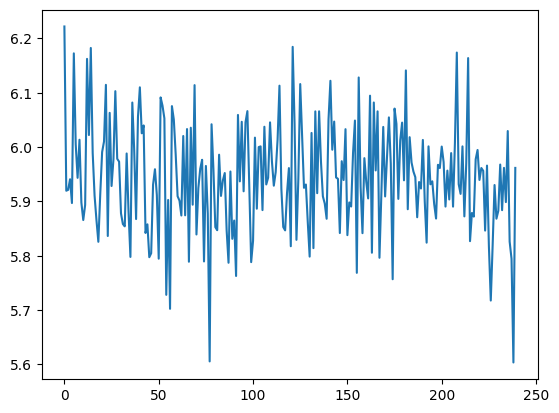

In [164]:
ax = params.Loss.plot().get_figure()
ax.savefig("./Figures/DAX_loss.png")

In [158]:
params.loc[params.Loss == min(params.Loss)]

p     q      Loss
238  15.0  14.0  5.603502

In [ ]:
params[[p[0] for p in params].index(min([p[0] for p in params]))]

p = 8 and q = 0 appear to be the best parameters for the DAX GARCH model!

## Energy

In [166]:
%%capture
eparams = pd.DataFrame({"p":[np.nan*225], "q": [np.nan*225], "Loss": [np.nan*225]})
c=0
for p in range(1, 16):
    for q in range(16):
        loss = energy_eval(energydata, p, q)
        eparams.loc[c, "p"] = p
        eparams.loc[c, "q"] = q
        eparams.loc[c, "Loss"] = loss
        c += 1

In [169]:
eparams.loc[eparams.Loss == min(eparams.Loss)]

p     q       Loss
75  5.0  11.0  17.321214

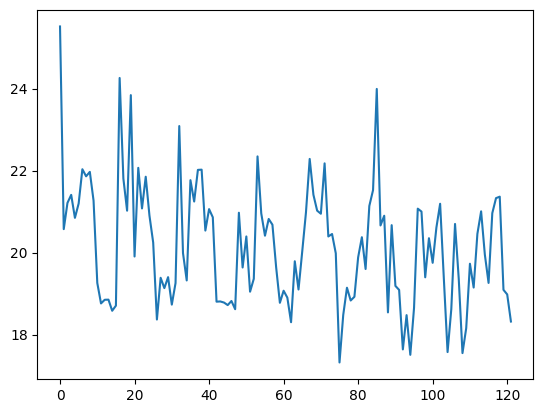

In [170]:
ax = eparams.Loss.plot().get_figure()
ax.savefig("./Figures/Energy_loss.png")

In [ ]:
params[[p[0] for p in params].index(min([p[0] for p in params]))]

In [ ]:
enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

In [ ]:
plot_pacf(enf12.data)

p = 9 and q = 9 appear to be the best parameters for Energy ARMA model!

# Backwards Evaluation

### Function

In [160]:
def evaluate_model(dates, daxdata, energydata):
    
    daxlosses = []
    energylosses = []
    daxevaldatas = []
    energyevaldatas = []

    for i in range(len(dates)-1):

        daxdatedata = daxdataAtDate(daxdata, dates[i])
        energydatedata = energydataAtDate(energydata, dates[i])

        #################################################################################################
        forecast = create_submission(dax_model(daxdatedata, 15, 14), energy_model(energydatedata, 5, 11)) ## Insert Models here
        #################################################################################################

        daxforecast = forecast.loc[forecast["target"] == "DAX"]
        energyforecast = forecast.loc[forecast["target"] == "energy"]

        daxevaldata = daxdataAtDate(daxdata, dates[i+1]).tail()
        daxevaldata.loc[:,"data"] = daxevaldata.data.cumsum()
        daxevaldata["q0.025"] = np.array(daxforecast["q0.025"])
        daxevaldata["q0.25"] = np.array(daxforecast["q0.25"])
        daxevaldata["q0.5"] = np.array(daxforecast["q0.5"])
        daxevaldata["q0.75"] = np.array(daxforecast["q0.75"])
        daxevaldata["q0.975"] = np.array(daxforecast["q0.975"])
        daxevaldatas.append(daxevaldata)

        energyevaldata = energydataAtDate(energydata, dates[i+1]).tail(168)
        enf12 = energyevaldata.loc[(energyevaldata.index.dayofweek == 4) & (energyevaldata.index.hour == 12)]
        enf16 = energyevaldata.loc[(energyevaldata.index.dayofweek == 4) & (energyevaldata.index.hour == 16)]
        enf20 = energyevaldata.loc[(energyevaldata.index.dayofweek == 4) & (energyevaldata.index.hour == 20)]
        ens12 = energyevaldata.loc[(energyevaldata.index.dayofweek == 5) & (energyevaldata.index.hour == 12)]
        ens16 = energyevaldata.loc[(energyevaldata.index.dayofweek == 5) & (energyevaldata.index.hour == 16)]
        ens20 = energyevaldata.loc[(energyevaldata.index.dayofweek == 5) & (energyevaldata.index.hour == 20)]
        energyevaldata = pd.concat([enf12, enf16, enf20, ens12, ens16, ens20])

        energyevaldata["q0.025"] = np.array(energyforecast["q0.025"])
        energyevaldata["q0.25"] = np.array(energyforecast["q0.25"])
        energyevaldata["q0.5"] = np.array(energyforecast["q0.5"])
        energyevaldata["q0.75"] = np.array(energyforecast["q0.75"])
        energyevaldata["q0.975"] = np.array(energyforecast["q0.975"])
        energyevaldata.data = energyevaldata.data / 1000
        energyevaldatas.append(energyevaldata)

        daxloss = 0
        for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
            for i in range(len(daxevaldata)):
                daxloss += quantile_loss(daxevaldata["data"].iloc[i], daxevaldata[q].iloc[i], float(q[1:]))
        daxlosses.append(daxloss)

        energyloss = 0
        for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
            for i in range(len(energyevaldata)):
                energyloss += quantile_loss(energyevaldata["data"].iloc[i], energyevaldata[q].iloc[i], float(q[1:]))
        energylosses.append(energyloss)

    return daxlosses, energylosses, daxevaldatas, energyevaldatas

### Execution

In [11]:
daxdata = get_dax_data()
energydata = get_energy_data()

In [134]:
list_of_submission_dates = ["2022-11-09", "2022-11-16", "2022-11-23", "2022-11-30", "2022-12-07", "2022-12-14", "2022-12-21", "2023-01-11", "2023-01-18", "2023-01-25", "2023-02-01", "2023-02-08"]

In [9]:
few_dates = ["2022-11-09", "2022-11-16", "2022-11-23"]

In [161]:
%%capture
daxlosses1, energylosses1, daxevaldatas1, energyevaldatas1 = evaluate_model(list_of_submission_dates, daxdata, energydata)

In [165]:
sum(energylosses1)

306.4044051476159

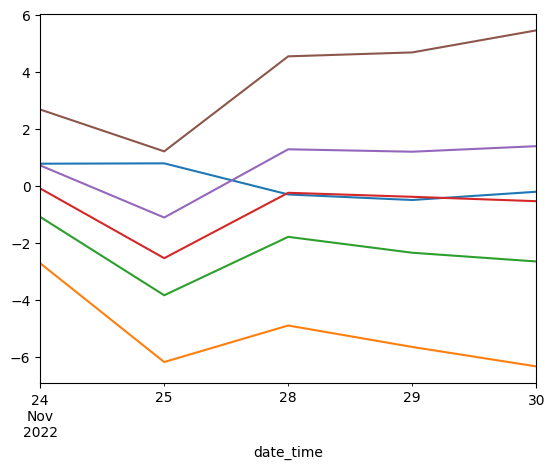

In [149]:
daxevaldatas[2].plot(legend=False).get_figure().savefig("./Figures/DAX_prophet_quantiles.png")


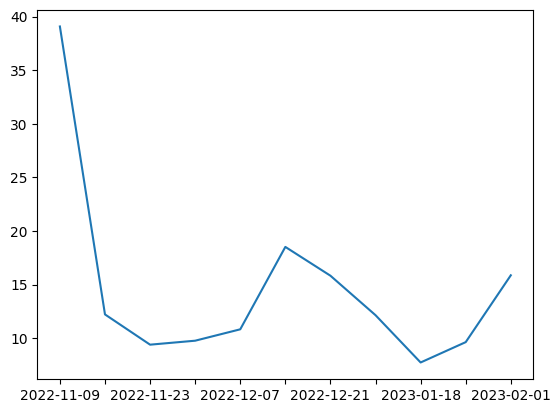

In [163]:
fig, ax = plt.subplots()
plt.plot(list_of_submission_dates[:-1], daxlosses)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

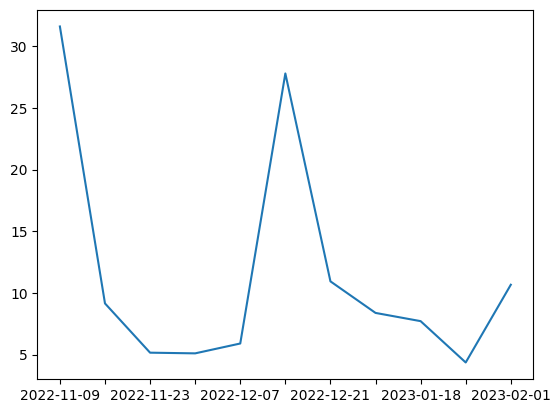

In [26]:
fig, ax = plt.subplots()
plt.plot(list_of_submission_dates[:-1], daxlosses)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig("./Figures/DAX_eval.png")

In [139]:
energyevaldatas[0]

data        q0.025         q0.25          q0.5  \
date_time                                                                 
2022-11-11 12:00:00  65.02300  56154.016897  60502.373909  62926.428383   
2022-11-11 16:00:00  61.59425  51451.705099  56424.121332  58890.071924   
2022-11-11 20:00:00  57.67675  49450.001858  54388.850102  56804.062161   
2022-11-12 12:00:00  53.61375  48383.862966  53104.732977  55228.328014   
2022-11-12 16:00:00  51.10450  43035.323523  47841.267761  50224.532013   
2022-11-12 20:00:00  49.65350  40702.162248  45204.290193  47725.384322   

                            q0.75        q0.975  
date_time                                        
2022-11-11 12:00:00  65017.166609  69865.173772  
2022-11-11 16:00:00  61397.639638  65494.019216  
2022-11-11 20:00:00  59483.609720  63832.566412  
2022-11-12 12:00:00  57761.725907  61925.010405  
2022-11-12 16:00:00  52384.007321  56844.983676  
2022-11-12 20:00:00  49949.326285  54298.711363

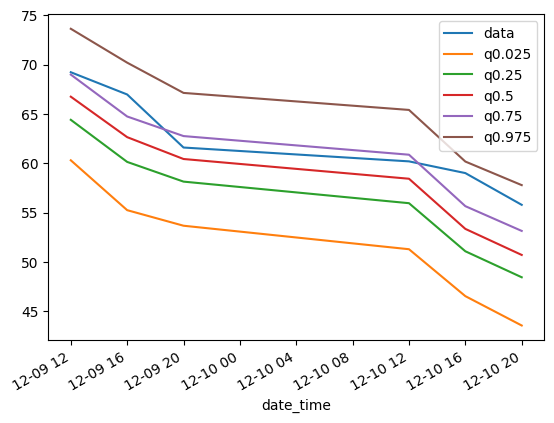

In [157]:
energyevaldatas[4].plot().get_figure().savefig("./Figures/Energy_prophet_quantiles.png")

In [159]:
sum(energylosses)

288.1479808266922

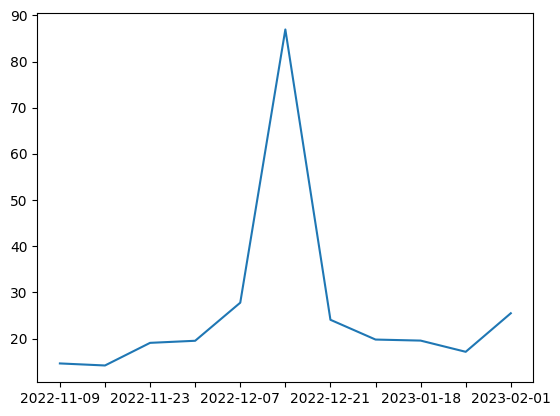

In [158]:
fig, ax = plt.subplots()
plt.plot(list_of_submission_dates[:-1], energylosses)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig("./Figures/Energy_prophet_loss.png")

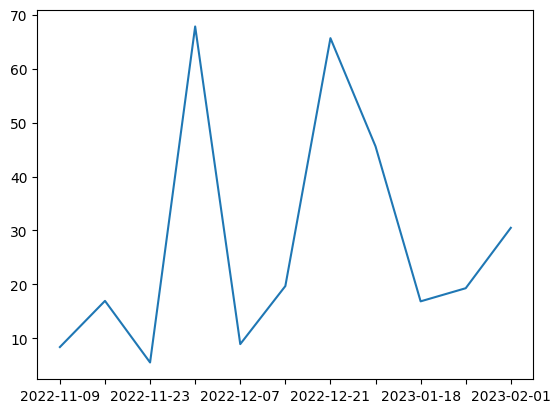

In [27]:
fig, ax = plt.subplots()
plt.plot(list_of_submission_dates[:-1], energylosses)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig("./Figures/Energy_eval.png")

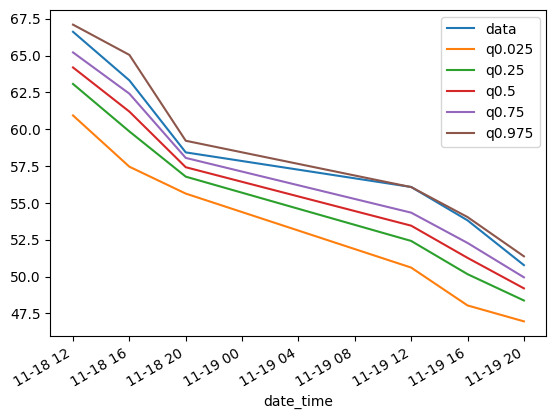

In [146]:
ax = energyevaldatas[1].plot().get_figure()
ax.savefig("./Figures/Energy_quantiles.png")

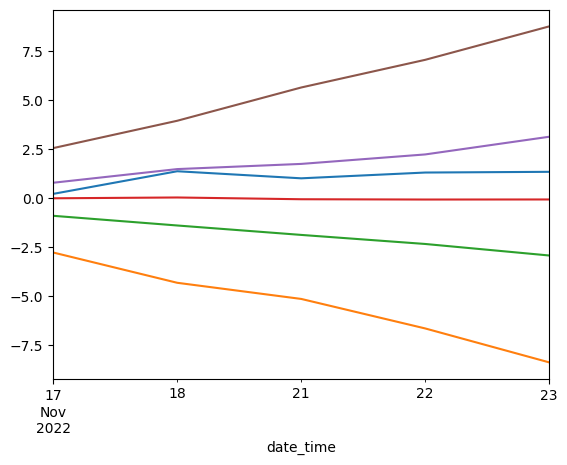

In [134]:
ax = daxevaldatas[1].plot(legend=False).get_figure()
ax.savefig("./Figures/DAX_quantiles.png")

# Submission Creation

In [167]:
%%capture

daxdata = get_dax_data()
energydata = get_energy_data()

submission = create_submission(dax_model(daxdata, 8, 0), energy_model(energydata, 9, 9))

In [173]:
submission

forecast_date  target  horizon     q0.025      q0.25       q0.5      q0.75  \
0     2023-02-15     DAX    1 day  -2.003603  -0.736780  -0.008086   0.642227   
1     2023-02-15     DAX    2 day  -2.214329  -0.697657   0.049251   0.823508   
2     2023-02-15     DAX    5 day  -2.972421  -1.076177   0.028501   1.111491   
3     2023-02-15     DAX    6 day  -3.326288  -1.233743  -0.073162   1.005111   
4     2023-02-15     DAX    7 day  -3.991823  -1.332390  -0.035990   1.285418   
5     2023-02-15  energy  36 hour  56.294889  64.189712  68.128887  71.923407   
6     2023-02-15  energy  40 hour  51.984777  58.236002  61.429841  64.804997   
7     2023-02-15  energy  44 hour  50.993773  56.581060  59.463391  61.882883   
8     2023-02-15  energy  60 hour  52.709536  56.563759  58.530959  60.629270   
9     2023-02-15  energy  64 hour  48.010242  51.735169  53.929892  55.900145   
10    2023-02-15  energy  68 hour  43.836894  49.502777  52.702230  55.483684   
11    2023-02-15    wind  36 hour        NaN        NaN        NaN        NaN   
12    2023-02-15    wind  48 hour        NaN        NaN        NaN        NaN   
13    2023-02-15    wind  60 hour        NaN        NaN        NaN        NaN   
14    2023-02-15    wind  72 hour        NaN        NaN        NaN        NaN   
15    2023-02-15    wind  84 hour        NaN        NaN        NaN        NaN   

       q0.975  
0    1.817469  
1    2.485135  
2    3.047506  
3    3.168742  
4    3.897796  
5   79.819040  
6   70.836044  
7   67.424148  
8   63.921008  
9   59.328411  
10  60.890926  
11        NaN  
12        NaN  
13        NaN  
14        NaN  
15        NaN

In [174]:
create_submission_file(submission)

Submission file created


# Check

In [175]:
! python check.py -p 20230215_GreyWorm.csv

{'path': '20230215_GreyWorm.csv', 'exclude_weather': None}
Loading file... 20230215_GreyWorm.csv
File loaded! Start Checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- wind -- is your NaN-target. Please DOUBLECHECK if this is correct.
---------------------------
Looks good!


# Testing

## DAX

In [ ]:
dax_eval(daxdata, 8, 0)

In [32]:
daxdata = get_dax_data()
daxtraindata = daxdata[:-5]
daxtestdata = daxdata[-5:]

In [35]:
daxtraindata = daxtraindata[:-1]

In [36]:
daxtraindata.tail()

data
date_time                          
2022-11-24 00:00:00+01:00  0.773085
2022-11-25 00:00:00+01:00  0.012519
2022-11-28 00:00:00+01:00 -1.092636
2022-11-29 00:00:00+01:00 -0.194233
2022-11-30 00:00:00+01:00  0.289296

In [33]:
daxtestdata.tail(10)

data
date_time                          
2022-12-02 00:00:00+01:00  0.269402
2022-12-05 00:00:00+01:00 -0.564444
2022-12-06 00:00:00+01:00 -0.725373
2022-12-07 00:00:00+01:00 -0.573340
2022-12-08 00:00:00+01:00  0.002520

In [37]:
daxforecast = dax_model(daxtraindata, 8, 0)

Iteration:      1,   Func. Count:     11,   Neg. LLF: 21987.052345579705
Iteration:      2,   Func. Count:     25,   Neg. LLF: 938241.0751811876
Iteration:      3,   Func. Count:     36,   Neg. LLF: 212869.26953076536
Iteration:      4,   Func. Count:     47,   Neg. LLF: 3103041.7307996266
Iteration:      5,   Func. Count:     58,   Neg. LLF: 1135931.3395410213
Iteration:      6,   Func. Count:     69,   Neg. LLF: 2352846.1306259623
Iteration:      7,   Func. Count:     80,   Neg. LLF: 5439360.131719231
Iteration:      8,   Func. Count:     91,   Neg. LLF: 151381.36406252274
Iteration:      9,   Func. Count:    102,   Neg. LLF: 118675.54059931201
Iteration:     10,   Func. Count:    114,   Neg. LLF: 32093.021593741127
Iteration:     11,   Func. Count:    125,   Neg. LLF: 18297.262599226837
Iteration:     12,   Func. Count:    138,   Neg. LLF: 17301.787239976205
Iteration:     13,   Func. Count:    149,   Neg. LLF: 14929.26711275553
Iteration:     14,   Func. Count:    160,   Neg. LLF: 

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [51]:
daxforecast = daxquantiles

In [52]:
daxforecast = pd.DataFrame(daxforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

In [53]:
daxforecast["q0.025"]

0   -1.771028
1   -1.681815
2   -1.708725
3   -1.858137
4   -1.802966
Name: q0.025, dtype: float64

In [54]:
daxtestdata

data
date_time                          
2022-12-02 00:00:00+01:00  0.269402
2022-12-05 00:00:00+01:00 -0.564444
2022-12-06 00:00:00+01:00 -0.725373
2022-12-07 00:00:00+01:00 -0.573340
2022-12-08 00:00:00+01:00  0.002520

In [55]:
daxevaldata = daxtestdata.copy(deep=True)
daxevaldata["q0.025"] = np.array(daxforecast["q0.025"])
daxevaldata["q0.25"] = np.array(daxforecast["q0.25"])
daxevaldata["q0.5"] = np.array(daxforecast["q0.5"])
daxevaldata["q0.75"] = np.array(daxforecast["q0.75"])
daxevaldata["q0.975"] = np.array(daxforecast["q0.975"])

In [56]:
daxevaldata

data    q0.025     q0.25      q0.5     q0.75  \
date_time                                                                     
2022-12-02 00:00:00+01:00  0.269402 -1.771028 -0.592881  0.002385  0.568405   
2022-12-05 00:00:00+01:00 -0.564444 -1.681815 -0.514817  0.008956  0.579739   
2022-12-06 00:00:00+01:00 -0.725373 -1.708725 -0.584207 -0.070837  0.523678   
2022-12-07 00:00:00+01:00 -0.573340 -1.858137 -0.535608  0.058867  0.626670   
2022-12-08 00:00:00+01:00  0.002520 -1.802966 -0.568414 -0.031261  0.589923   

                             q0.975  
date_time                            
2022-12-02 00:00:00+01:00  1.571374  
2022-12-05 00:00:00+01:00  1.704298  
2022-12-06 00:00:00+01:00  1.585192  
2022-12-07 00:00:00+01:00  1.689839  
2022-12-08 00:00:00+01:00  1.809461

<AxesSubplot: xlabel='date_time'>

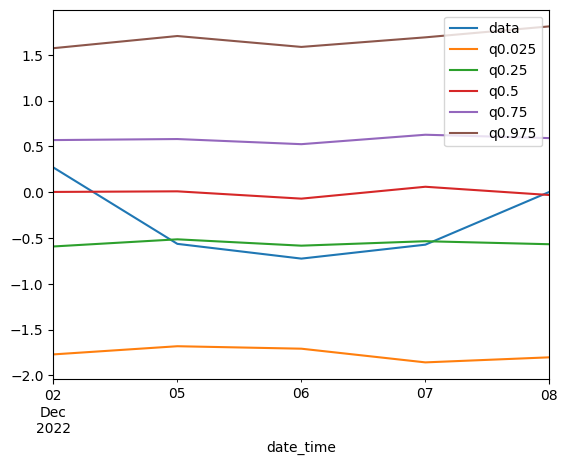

In [57]:
daxevaldata.plot()

In [ ]:
totalloss = 0
for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
    for i in range(len(daxevaldata)):
        totalloss += quantile_loss(daxevaldata["data"].iloc[i], daxevaldata[q].iloc[i], float(q[1:]))
totalloss

## Energy

In [ ]:
energy_eval(energydata, 9, 9)

In [21]:
#energydata = get_energy_data()
energytraindata = energydata[:-168]
energytestdata = energydata[-168:]

In [19]:
energydata = energydata[:-17]

In [20]:
energydata.tail()

data
date_time                    
2022-12-07 18:00:00  67479.25
2022-12-07 19:00:00  66052.75
2022-12-07 20:00:00  62895.25
2022-12-07 21:00:00  59129.75
2022-12-07 22:00:00  56350.50

In [22]:
energytraindata.tail(10)

data
date_time                    
2022-11-30 13:00:00  67973.25
2022-11-30 14:00:00  66967.50
2022-11-30 15:00:00  66610.50
2022-11-30 16:00:00  67620.75
2022-11-30 17:00:00  68307.75
2022-11-30 18:00:00  67527.75
2022-11-30 19:00:00  65256.75
2022-11-30 20:00:00  62250.50
2022-11-30 21:00:00  59947.00
2022-11-30 22:00:00  57459.25

In [25]:
energytestdata

data
date_time                    
2022-12-02 12:00:00  69728.50
2022-12-02 16:00:00  67892.75
2022-12-02 20:00:00  62636.25
2022-12-03 12:00:00  59507.50
2022-12-03 16:00:00  57388.50
2022-12-03 20:00:00  53896.75

In [24]:
enf12 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 12)]
enf16 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 16)]
enf20 = energytestdata.loc[(energytestdata.index.dayofweek == 4) & (energytestdata.index.hour == 20)]

ens12 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 12)]
ens16 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 16)]
ens20 = energytestdata.loc[(energytestdata.index.dayofweek == 5) & (energytestdata.index.hour == 20)]

energytestdata = pd.concat([enf12, enf16, enf20, ens12, ens16, ens20])

In [26]:
energyforecast = energy_model(energytraindata, 9, 9)

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Caskroom/

In [27]:
energyforecast

[array([65.44615941, 67.18298359, 68.09937038, 69.01492829, 70.87593812]),
 array([58.48116138, 60.79785166, 61.91323361, 63.03115172, 65.23335443]),
 array([56.35967519, 57.71709152, 58.32457335, 58.93943455, 60.15048401]),
 array([53.422775  , 54.7836875 , 55.57202718, 56.30495362, 57.69694616]),
 array([49.48132348, 51.44763075, 52.60960234, 53.89610267, 56.24323301]),
 array([48.90431982, 50.24054962, 50.89859014, 51.65896977, 52.99843377])]

In [28]:
energyforecast = pd.DataFrame(energyforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

In [29]:
energyevaldata = energytestdata.copy(deep=True)
energyevaldata["q0.025"] = np.array(energyforecast["q0.025"])
energyevaldata["q0.25"] = np.array(energyforecast["q0.25"])
energyevaldata["q0.5"] = np.array(energyforecast["q0.5"])
energyevaldata["q0.75"] = np.array(energyforecast["q0.75"])
energyevaldata["q0.975"] = np.array(energyforecast["q0.975"])

In [30]:
energyevaldata.data = energyevaldata.data / 1000

In [31]:
energyevaldata

data     q0.025      q0.25       q0.5      q0.75  \
date_time                                                                   
2022-12-02 12:00:00  69.72850  65.446159  67.182984  68.099370  69.014928   
2022-12-02 16:00:00  67.89275  58.481161  60.797852  61.913234  63.031152   
2022-12-02 20:00:00  62.63625  56.359675  57.717092  58.324573  58.939435   
2022-12-03 12:00:00  59.50750  53.422775  54.783687  55.572027  56.304954   
2022-12-03 16:00:00  57.38850  49.481323  51.447631  52.609602  53.896103   
2022-12-03 20:00:00  53.89675  48.904320  50.240550  50.898590  51.658970   

                        q0.975  
date_time                       
2022-12-02 12:00:00  70.875938  
2022-12-02 16:00:00  65.233354  
2022-12-02 20:00:00  60.150484  
2022-12-03 12:00:00  57.696946  
2022-12-03 16:00:00  56.243233  
2022-12-03 20:00:00  52.998434

In [ ]:
energyevaldata.plot()

In [ ]:
totalloss = 0
for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
    for i in range(len(energyevaldata)):
        totalloss += quantile_loss(energyevaldata["data"].iloc[i], energyevaldata[q].iloc[i], float(q[1:]))
totalloss

# Analysis

## Energy

In [88]:
len(energydata.tail(1440))

1440

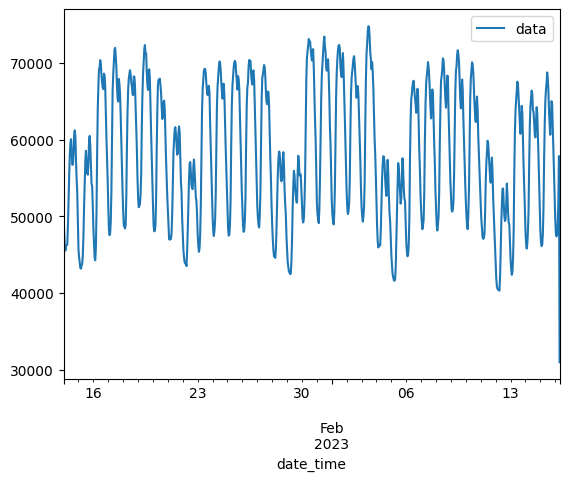

In [100]:
energydata = energydata.loc[energydata.data != 0]
ax = energydata.tail(800).plot().get_figure()
ax.savefig("./Figures/Energy_weekly.png")

<AxesSubplot: xlabel='date_time'>

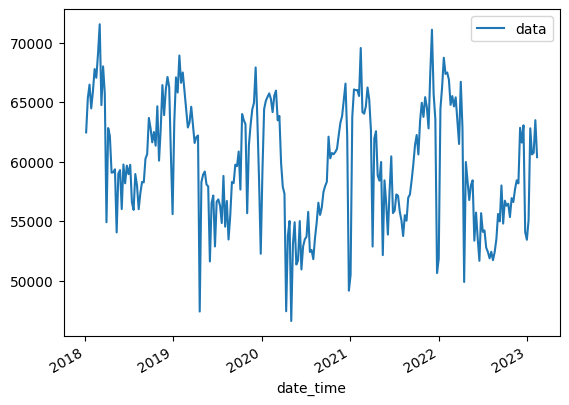

In [101]:
enf20.plot()

In [62]:
enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

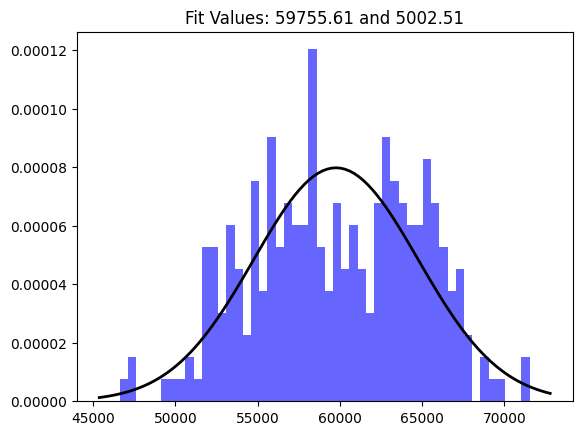

In [79]:
mu, std = scipy.stats.norm.fit(enf20["data"])

# Plot the histogram.
plt.hist(enf20["data"], bins=50, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

plt.savefig("./Figures/Energy_distribution.png")

In [72]:
enf20["data"].describe()

count      267.000000
mean     59755.611423
std       5011.908304
min      46613.500000
25%      55852.750000
50%      59730.250000
75%      63833.000000
max      71534.250000
Name: data, dtype: float64

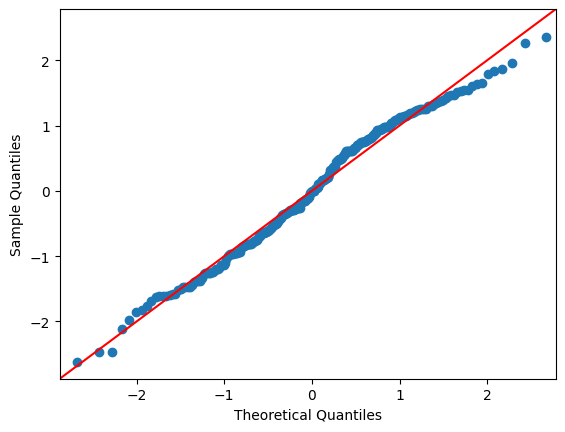

In [76]:
ax = sm.qqplot((enf20["data"]-59755)/5002, line="45").get_figure()

ax.savefig("./Figures/Energy_qqplot")

## DAX

<AxesSubplot: xlabel='date_time'>

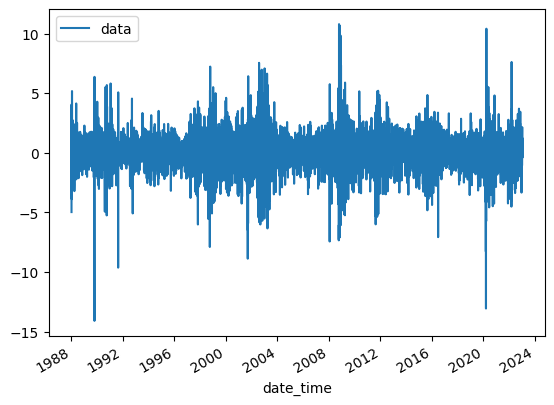

In [36]:
daxdata.plot()

In [43]:
sm.stats.diagnostic.kstest_normal(daxdata["data"], dist='norm', pvalmethod='table')

(0.06921595702341099, 0.0009999999999998899)

In [80]:
m=10
df=0
for i in range(300):
    if scipy.stats.kstest(daxdata["data"], "t", args=[i]).statistic < m:
        df = i
        m = scipy.stats.kstest(daxdata["data"], "t", args=[i]).statistic
df

68

In [74]:
scipy.stats.kstest(daxdata["data"], "norm").statistic

0.039698413254744734

In [81]:
scipy.stats.kstest(daxdata["data"], "t", args=[68])

KstestResult(statistic=0.037451246498678537, pvalue=3.174404008291038e-11)

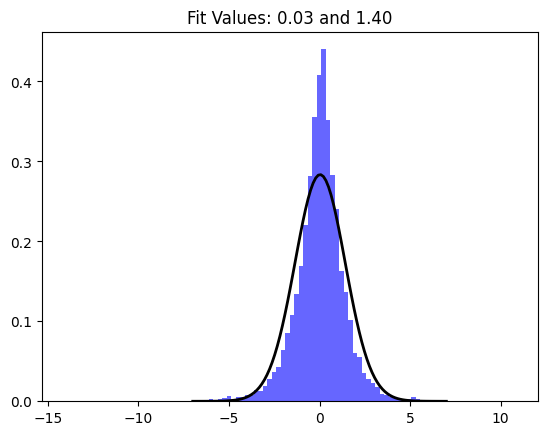

1.4018401797842488

In [110]:
mu, std = scipy.stats.norm.fit(daxdata["data"])

# Plot the histogram.
plt.hist(daxdata["data"], bins=100, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(-7, 7, 100)
p = scipy.stats.t.pdf(x, 68, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

plt.show()
std

In [83]:
x

array([-15.33559743, -15.05905705, -14.78251668, -14.5059763 ,
       -14.22943593, -13.95289555, -13.67635517, -13.3998148 ,
       -13.12327442, -12.84673405, -12.57019367, -12.2936533 ,
       -12.01711292, -11.74057255, -11.46403217, -11.18749179,
       -10.91095142, -10.63441104, -10.35787067, -10.08133029,
        -9.80478992,  -9.52824954,  -9.25170917,  -8.97516879,
        -8.69862842,  -8.42208804,  -8.14554766,  -7.86900729,
        -7.59246691,  -7.31592654,  -7.03938616,  -6.76284579,
        -6.48630541,  -6.20976504,  -5.93322466,  -5.65668428,
        -5.38014391,  -5.10360353,  -4.82706316,  -4.55052278,
        -4.27398241,  -3.99744203,  -3.72090166,  -3.44436128,
        -3.1678209 ,  -2.89128053,  -2.61474015,  -2.33819978,
        -2.0616594 ,  -1.78511903,  -1.50857865,  -1.23203828,
        -0.9554979 ,  -0.67895752,  -0.40241715,  -0.12587677,
         0.1506636 ,   0.42720398,   0.70374435,   0.98028473,
         1.2568251 ,   1.53336548,   1.80990586,   2.08

# Analysis 2

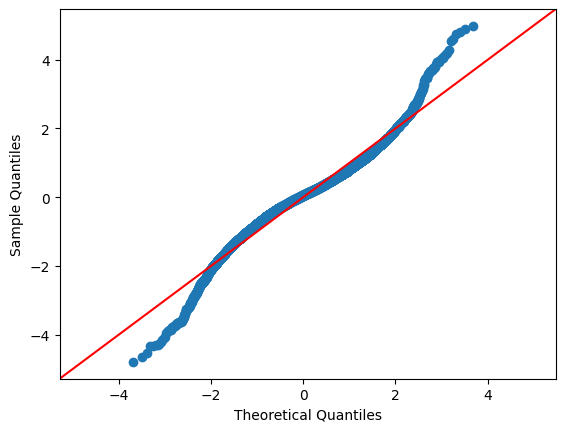

In [69]:
ax = sm.qqplot(data.loc[(data["data"] < 7) & (data["data"] > -7)].data, line="45").get_figure()

ax.savefig("./Figures/DAX_qqplot")

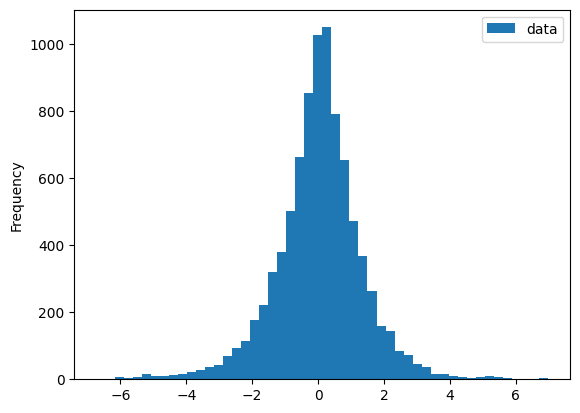

In [70]:
ax = (data.loc[(data["data"] < 7) & (data["data"] > -7)]).plot.hist(bins=50, grid=False).get_figure().savefig("./Figures/DAX_distribution.png")


In [109]:
d = []
for i in range(len(data)-1, 5, -1):
    d.append(data["data"][i: i-5: -1].sum())
d = d[::-1]
df = data.copy()
df = df[6:]
df["data"] = d

<AxesSubplot: ylabel='Frequency'>

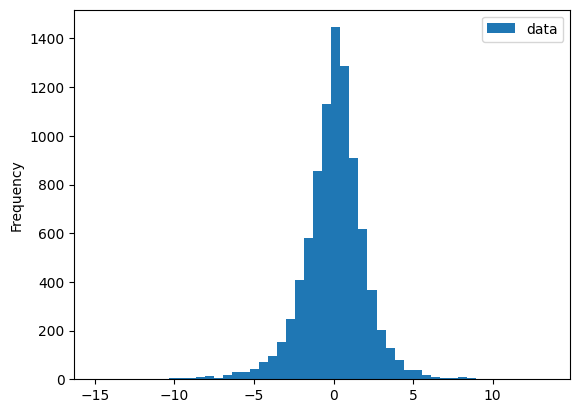

In [105]:
df.plot.hist(bins=50, grid=False)

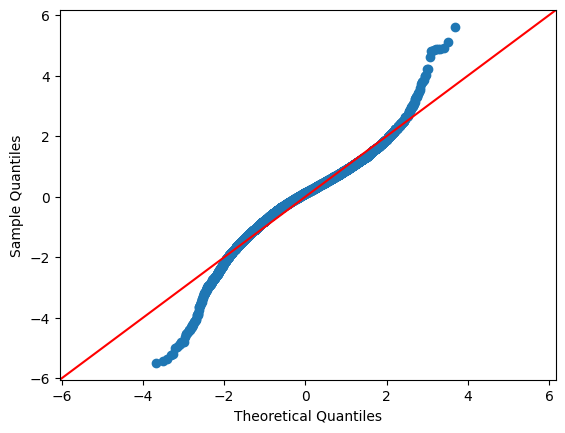

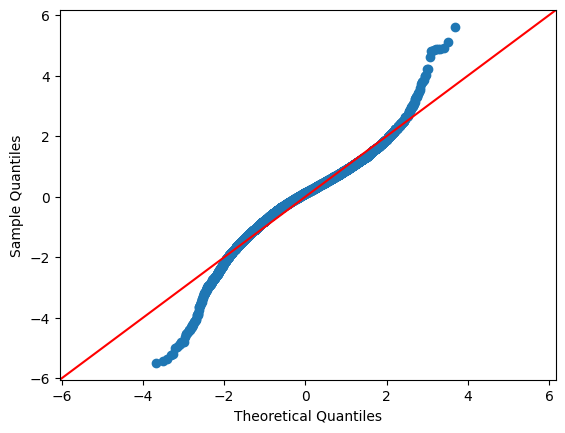

In [111]:
sm.qqplot(df.loc[(df["data"] < 18) & (df["data"] > -18)].data / 3.06, line="45").get_figure()

In [115]:
stds = []
for j in range(1,50):
    d = []
    step = j
    for i in range(len(daxdata)-1, 50, -1):
        d.append(daxdata["data"][i: i-step: -1].sum())
    d = d[::-1]
    df = daxdata.copy()
    df = df[51:]
    df["data"] = d
    stds.append(df.data.describe()["std"])

stds = [std**2 for std in stds]

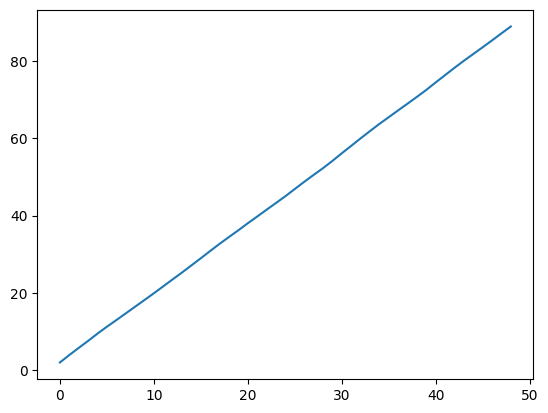

In [119]:
plt.plot(stds)
plt.show()